In [1]:
import numpy as np
from astropy.table import Table, vstack, Column
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import warnings
import seaborn as sns
import py_specrebin

In [2]:
path = '.\\..\\catalogs\\'
fileDE = Table.read(path+'VDGC_pPXF_2017_v2.fits')
fileUDG = Table.read(path+'VUGC_pPXF_2017_v2.fits')

In [3]:
columns_to_change = ['ZERR', 'ZERR_ne', 'ZERR_pe', 'ZHEL', 'ZOBS', 'ZOBS_ne', 'ZOBS_pe']
columns_to_change2 = ['HELCOR','ABANDCOR', 'ABANDCOR_ne', 'ABANDCOR_pe']     #rename columns for the DE
for col in columns_to_change:
    fileDE[col] = fileDE[col] * 3e+5
    fileDE.rename_column(col, 'V' + col[1:]) 
for col in columns_to_change2:
    fileDE[col] = fileDE[col] * 3e+5

In [4]:
DE_GC = fileDE[fileDE['ZCONF']==1]      #cuts down to ZCONF = 1
DE_GC = DE_GC[DE_GC['GCSAT']== 'Y']     #cuts down to GCSAT = yes
UDG_GC = fileUDG[fileUDG['ZCONF']==1]
UDG_GC = UDG_GC[UDG_GC['GCSAT']== 'Y']
intermediate = UDG_GC.copy()
udg_bool = (UDG_GC['HOST'] == 'VLSB-B') | (UDG_GC['HOST'] == 'VLSB-D') | (UDG_GC['HOST'] == 'VCC0615')
UDG_GC= UDG_GC[udg_bool]
belongDGC = ~udg_bool
DE_GC = vstack([DE_GC, intermediate[belongDGC]])     #combines DE_GC with the rows originally from UDG data
# DE_GC.remove_rows(np.nonzero((DE_GC['VHEL'] > -300) & (DE_GC['VHEL'] < 300))[0])     #removes potential milky way stars
# UDG_GC.remove_rows(np.no vgvvggggggggggggggggggggggggggggggggginzero((UDG_GC['VHEL'] > -300) & (UDG_GC['VHEL'] < 300))[0])

In [5]:
fileOrphanDE = Table.read(path+'orphanGCs.fits')
filekinDE = Table.read(path+'VDGC_kinematic_prob.fits')
fileOrphanUDG = Table.read(path+'SelectGCsTrue2.fits')
filekinUDG = Table.read(path+'SelectGCsTrue_kinematic_prob.fits')
def typeandprob(file):
    probability = []
    objecttype = []
    for row in file:
        probability.append(max(row))
        vals = []
        for val in row:
            vals.append(val)
        if (vals.index(max(vals))== 0):
            objecttype.append('Star')
        elif (vals.index(max(vals))== 1):
            objecttype.append('ICGC')
        elif (vals.index(max(vals))== 2):
            objecttype.append('M87GC')
    return probability, objecttype
probabilityDE, objecttypeDE = typeandprob(filekinDE)
probabilityUDG, objecttypeUDG = typeandprob(filekinUDG)
fileOrphanDE['Probability'] = probabilityDE
fileOrphanUDG['Probability'] = probabilityUDG
fileOrphanDE['Type'] = objecttypeDE
fileOrphanUDG['Type'] = objecttypeUDG

In [6]:
allnoDE = fileDE[(fileDE['ZCONF']==1) & ((fileDE['GCSAT'] == 'N') | (fileDE['GCSAT'] == 'M'))]        #gets all GCSATs that are NO and ZCONF that are 1 for DE
allnoUDG = fileUDG[(fileUDG['ZCONF']==1) & ((fileUDG['GCSAT'] == 'N') | (fileUDG['GCSAT'] == 'M'))]     #does same for the UDG
allnoDE.sort('SPEC1DNAME')     #organizes based on SPEC1DNAME for all tables, now since they are all sorted by the same manner their rows must correspond to one another
allnoUDG.sort('SPEC1DNAME')
fileOrphanDE.sort('SPEC1DNAME')
fileOrphanUDG.sort('SPEC1DNAME')
focusedUDG = fileOrphanUDG['SPEC1DNAME','Probability','Type']
focusedUDG.add_row(['spec1d.vugc1.044.GCXO0504.fits.gz',-1,'Unkwn'])
focusedUDG.sort('SPEC1DNAME')
allnoDE['Probability'] = probabilityDE
allnoUDG['Probability'] = focusedUDG['Probability']
allnoDE['Type'] = objecttypeDE
allnoUDG['Type'] = focusedUDG['Type']

In [7]:
DEtype = []
DEprob = []
UDGtype = []
UDGprob = []
for i in range(len(DE_GC)):
    DEtype.append('DE_GC')
    DEprob.append(1)
for i in range(len(UDG_GC)):
    UDGtype.append('UDG_GC')
    UDGprob.append(1)
DE_GC['Type'] = DEtype
DE_GC['Probability'] = DEprob
UDG_GC['Type'] = UDGtype
UDG_GC['Probability'] = UDGprob

In [8]:
finaltable = Table()
finaltable = vstack([DE_GC, UDG_GC])  
finaltable = vstack([finaltable, allnoDE])     
finaltable = vstack([finaltable, allnoUDG])
allnames = []
test = Table()
finaltable.sort('SPEC1DNAME')
for i in range (len(finaltable)):
    allnames.append(finaltable[i]['SPEC1DNAME'])
    allnames[i] = allnames[i][:-3]

In [9]:
nucDat = ascii.read(path + 'nuc.dat')
nucDat.sort('VCC')
finaltable.sort('VCC')
myVCC = []
nucVCC = []
for i in range (len(finaltable)):
    if (finaltable[i]['VCC'] == '---'):
        pass
    else:
        myVCC.append(finaltable[i]['VCC'])
for i in range(len(nucDat)):
    nucVCC.append(''+(str(nucDat[i]['name'][24:])))
for i in range(len(nucVCC)):
    if (nucVCC[i][0] == 'V'):
        pass
    else:
        nucVCC[i] = 'V' + nucVCC[i]
indexmatches = []
valmatches = []
sub = 'VCC'
UDGtingz = []
UDGtingz.append([s for s in myVCC if sub not in s])
UDGtingz = UDGtingz[0]
for i in range(len(UDGtingz)):
    myVCC.remove(UDGtingz[i])
zerocolon = []
for val in myVCC:
    if val not in nucVCC:
        zerocolon.append(val)
for val in zerocolon:
    myVCC.remove(val)
for val in myVCC:
    if val in nucVCC:
        valmatches.append(val)

In [10]:
nuclei = list(nucDat['Nucleus'])
finaltable['Nucleus'] = ' 0'
i = 0
for row in finaltable:
    if row['VCC'] == myVCC[i]:
        row['Nucleus'] = nuclei[i]
        row['Type'] = 'DE_NUC'
        if (i < len(myVCC)- 1):
            i += 1
        else:
            pass
    elif row['VCC'] in zerocolon:
        row['Nucleus'] = ':'
    elif row['VCC'] in UDGtingz:
        if row['TARGTYPE'] == 'NUC':
            row['Nucleus'] = '1'
        else:
            row['Nucleus'] = '0' 
    else:
        pass
for name in finaltable:
    name['SPEC1DNAME'] = name['SPEC1DNAME'][:-3]

In [11]:
path = '.\\..\\spectra\\'
vdgcfiles = []
vugcfiles = []
vugcfilesgz = []
for filename in os.listdir(path):                               #access files
    if ((filename in allnames) | (filename[:-3] in allnames)):        #open only necessary files (ones that exist in table)
        if ((filename.endswith(".fits")) & ("spec" in filename)): 
            vdgcfiles.append(filename)
        elif ((filename.endswith(".gz")) & ("spec" in filename)): 
            vugcfiles.append(filename[:-3])
            vugcfilesgz.append(filename)

In [12]:
vobsidxDE = []
vobsDE = []
finaltable.sort('SPEC1DNAME')                      #sort based on name
for file in vdgcfiles:
    for ind, val in enumerate(allnames):
        if file == val:
            vobsidxDE.append(ind)                  #find matching rows in table to get the VOBS
for index in vobsidxDE:
    vobsDE.append(finaltable[index]['VOBS'])         #get VOBS
vobsidxUDG = []
vobsUDG = []
for file in vugcfiles:                          #same for UDG
    for ind, val in enumerate(allnames):
        if file == val:
            vobsidxUDG.append(ind)
for index in vobsidxUDG:
    vobsUDG.append(finaltable[index]['VOBS'])

In [13]:
alllambdas = []
allfluxes = []
allvariances = []
def coaddition(files, velocities):
    for i in range(len(files)):
        f = fits.open(path + files[i])        #open file
        try:                                  #check for Bxspf blue or red, if not I resort to Horne
            tempB = f['Bxspf-' + 'B']
        except:
            tempB = f['Horne-' + 'B']   
        try:
            tempR = f['Bxspf-' + 'R']
        except:
            tempR = f['Horne-' + 'R'] 
        newwaveB = tempB.data['LAMBDA']                                
        oldwaveB = newwaveB/(1 + ((velocities[i]/300000)))     #doppler shift correction
        newwaveR = tempR.data['LAMBDA']
        oldwaveR = newwaveR/(1 + ((velocities[i]/300000)))        #doppler shift correction
        alllambdas.append(np.append(oldwaveB,oldwaveR))        #this is a 1D list of blue side lambdas then red
        allfluxes.append(np.append(tempB.data['SPEC'],tempR.data['SPEC']))     #1D list of blue then red fluxes
        allvariances.append(np.append(tempB.data['IVAR'], tempR.data['IVAR']))        #1D list of blue then red variances
        f.close()     #close file
    return alllambdas, allfluxes, allvariances 
RBlambdaDE, RBfluxDE, RBvarianceDE = coaddition(vdgcfiles, vobsDE)           #coaddition for DE
RBlambdaUDG, RBfluxUDG, RBvarianceUDG = coaddition(vugcfilesgz, vobsUDG)         #coaddition for UDG

In [14]:
testlambdaDE = RBlambdaDE[:10]
testfluxDE = RBfluxDE[:10]                       #get first 10 files so I can work with the data
testvarianceDE = RBvarianceDE[:10]
testlambdaUDG = RBlambdaUDG[:10]
testfluxUDG = RBfluxUDG[:10]
testvarianceUDG = RBvarianceUDG[:10]

In [15]:
correct = np.arange(4000,8750.9,0.9)          #generate new wavelengths to work with
fluxesDE,fluxesUDG = [], []
varsDE, varsUDG = [], []
for i in range(len(testlambdaDE)):  
    newfluxDE, newvarDE = py_specrebin.rebinspec(testlambdaDE[i],testfluxDE[i], correct, ivar = testvarianceDE[i])  #rebinspec DE
    fluxesDE.append(newfluxDE)
    varsDE.append(newvarDE)
for i in range(len(testlambdaUDG)):  
    newfluxUDG, newvarUDG = py_specrebin.rebinspec(testlambdaUDG[i],testfluxUDG[i], correct, ivar = testvarianceUDG[i]) #rebinspec UDG
    fluxesUDG.append(newfluxUDG)
    varsUDG.append(newvarUDG)

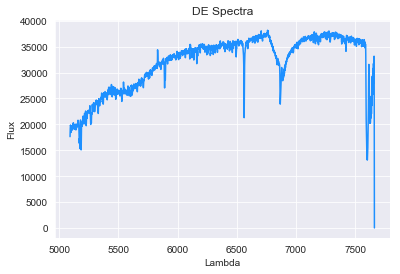

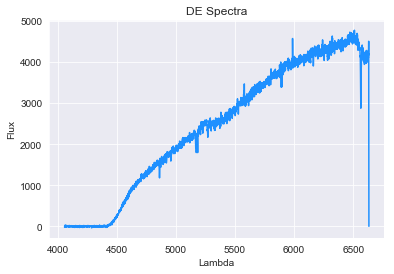

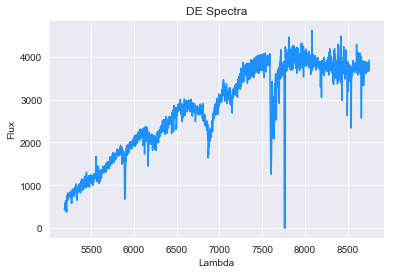

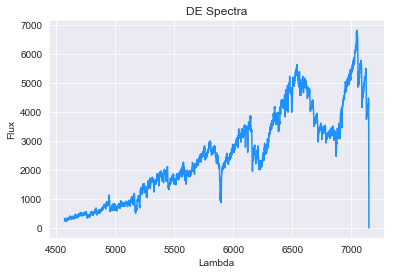

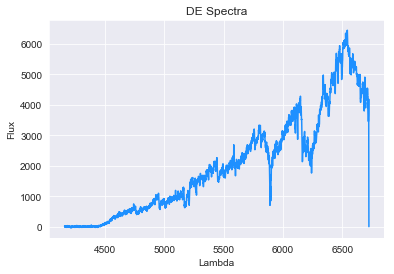

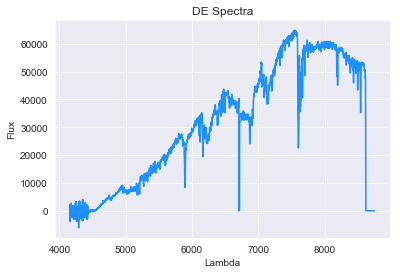

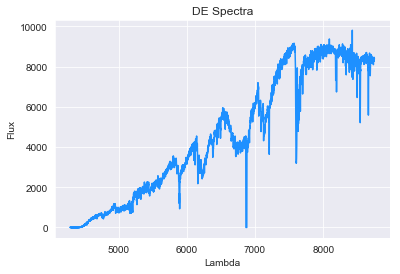

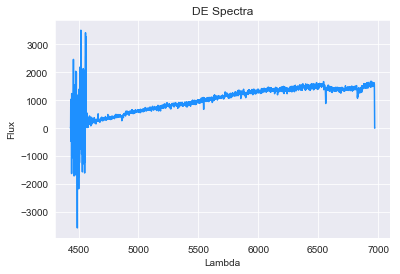

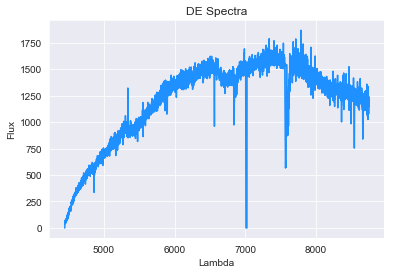

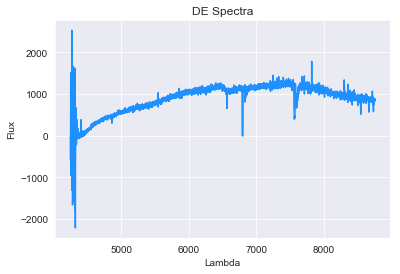

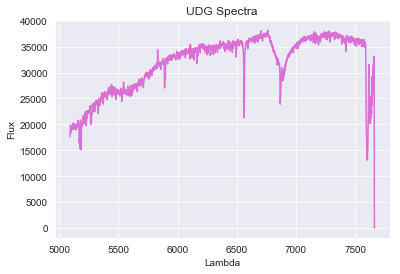

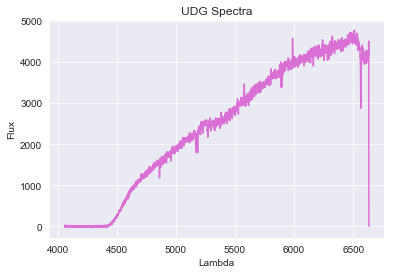

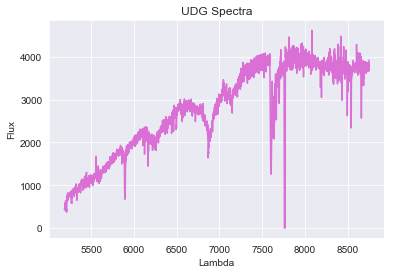

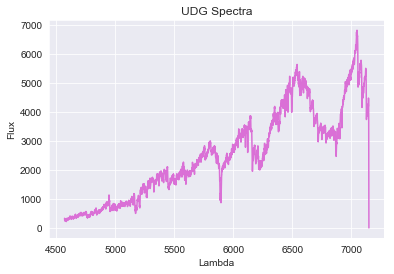

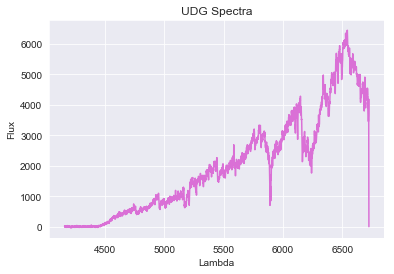

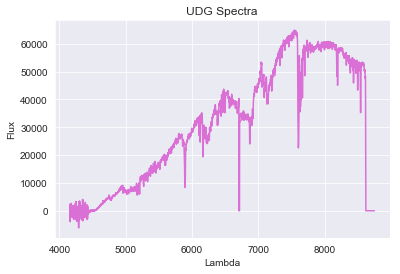

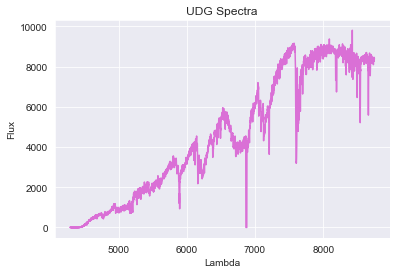

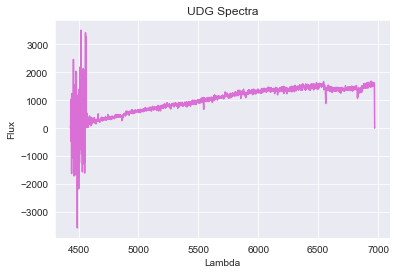

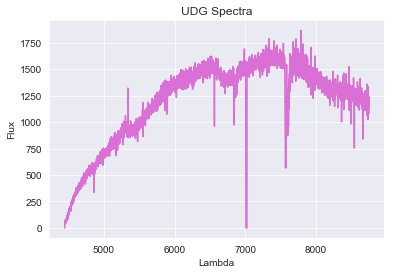

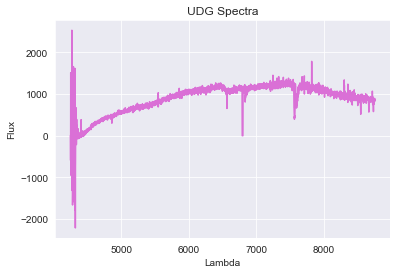

In [16]:
for i in range(len(fluxesDE)):
    sns.set_style('darkgrid')                     #plot DE
    g = sns.lineplot(correct,fluxesDE[i], color = 'dodgerblue')   
    g.set(xlabel='Lambda', ylabel='Flux', title='DE Spectra')
    plt.show()
for i in range(len(fluxesUDG)):           #plot UDG
    g = sns.lineplot(correct,fluxesUDG[i], color = 'orchid')   
    g.set(xlabel='Lambda', ylabel='Flux', title='UDG Spectra')
    plt.show()